In [1]:
import sys
sys.path.append('../../..')

from olfactory_navigation import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test

from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.agents.model_based_util.belief import Belief, BeliefSet
from olfactory_navigation.environment import _resize_array
from viz import plot_trajectory_in_tank

from matplotlib import pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from datetime import datetime

import pandas as pd
import numpy as np
import h5py
import os

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(3)

## Parameters

In [3]:
agent_speed = 4 # Walking speed cm/s
dt = 0.4 # s (walking for an average of 0.4s)
stop_dt = 1.3 # s (average stop time)
step_dt = dt + stop_dt
step_dist = agent_speed * dt # cm

max_time = 900 # s (Experiments topped after 15mins)
max_steps = int(max_time / step_dt)

multiplier = agent_speed * dt
actual_tank_size = np.array([90,114]) # actual size: 90cm x 114cm but it is scaled by a walking speed of <multiplier>
tank_size = (actual_tank_size / multiplier).astype(int)
space_shape = (tank_size * 2) + 1

source_position = tank_size

goal_radius = 1
# odor_radius = 10.5
odor_radius = 3 / multiplier # 3 cm * 0.8 -> 3.75 grid units

print(f'Tank size: {tank_size.tolist()}; Space shape {space_shape.tolist()}; States count: {space_shape.prod()}')

Tank size: [56, 71]; Space shape [113, 143]; States count: 16159


In [16]:
# Folder variables
experiment_data_file = f'/storage/arnaud/datasets/2024_11_22_sea_robins_experimental_data/experimental_positions.csv'
test_result_folder = f'./results-only_legs-{datetime.now().strftime("%Y%m%d_%H%M%S")}/'

## Building POMDP Model

In [5]:
# Legs odor field
odor_field = np.zeros(space_shape)
odor_field_indices = np.array(list(np.ndindex(tuple(space_shape))))

in_odor_plume = np.sum((odor_field_indices - tank_size[None,:])**2, axis=1) <= (odor_radius ** 2)
odor_field[*odor_field_indices[in_odor_plume].T] = 1.0

In [6]:
thresholds = np.array([-np.inf,1,np.inf])
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

In [7]:
# Base Model parameters
state_count = np.prod(space_shape)

state_grid = [[f's_{x}_{y}' for x in range(space_shape[1])] for y in range(space_shape[0])]
end_states = np.argwhere(np.fromfunction(lambda x,y: ((x-source_position[0])**2 + (y-source_position[1])**2) <= goal_radius**2,
                                            shape=space_shape).ravel())[:,0].tolist()

# Counts
action_count = len(action_set)
observation_count = thresholds.shape[-1] # Thresholds minus 1; plus 1 for the goal.

# Building observation matrix
observations = np.empty((state_count, action_count, observation_count), dtype=float)

observations[:,:,1] = odor_field.ravel()[:,None] # legs
observations[:,:,0] = 1.0 - observations[:,:,1] # Nothing

# Goal observation
observations[:,:,-1] = 0.0
observations[end_states,:,:] = 0.0
observations[end_states,:,-1] = 1.0

# Assert observations sum to 1
assert np.all(np.sum(observations, axis=2) == 1.0), "Observation table malformed, something is wrong..."

# Observation labels
observation_labels = ['nothing', 'something_legs', 'goal']

# Compute reachable states
points = np.array(np.unravel_index(np.arange(np.prod(space_shape)), space_shape)).T

# For each actions compute all new grid points (using the environment.move method)
action_new_states = []
movements = action_set
for move_vector in movements:

    # Applying the movement vector
    new_points = points + move_vector

    # Wrap points
    new_points = np.where(new_points < 0, (new_points + space_shape[None,:]), new_points)
    new_points = np.where(new_points >= space_shape[None,:], (new_points - space_shape[None,:]), new_points)

    new_states = np.ravel_multi_index((new_points[:,0], new_points[:,1]), dims=space_shape)
    action_new_states.append(new_states)

# Forming it the reachable states array from the new states for each action
reachable_states = np.array(action_new_states).T[:,:,None]

# Instantiate the model object
model = Model(
    states = state_grid,
    actions = action_labels,
    observations = observation_labels,
    reachable_states = reachable_states,
    observation_table = observations,
    end_states = end_states
)

## Building environment

In [8]:
env = Environment(data_file=odor_field[None,:,:],
                  data_source_position=tank_size,
                  source_radius=goal_radius,
                  boundary_condition='wrap')

## Agent Training

In [9]:
ag = FSVI_Agent(env,
                model=model,
                thresholds=[-np.inf, 1.0, 2.0, np.inf])

In [10]:
_ = ag.train(expansions=800,
             max_belief_growth=100,
             eps=1e-8,
             use_gpu=True)

[01/10/2025, 15:17:27] MDP_policy, not provided. Solving MDP with Value Iteration...
[01/10/2025, 15:17:27] Sending Model to GPU...
[01/10/2025, 15:17:28]     > Done in 0.197s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 16159-state, 4-action
  - Converged in 1000 iterations and 0.9362 seconds
  - Took on average 0.0009s per iteration


Expansions:   0%|          | 0/800 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 16159 state, 4 action, 3 observations
  - Converged or stopped after 800 expansion steps and 800 backup steps.
  - Resulting value function has 7201 alpha vectors.
  - Converged in 236.2728s

  - Expand function took on average 0.0655s and yielded on average 7857.49 beliefs per iteration. (0.0000s/it/belief)
  - Backup function took on average 0.2298s and yielded on average 9.00 alpha vectors per iteration. (0.0002s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


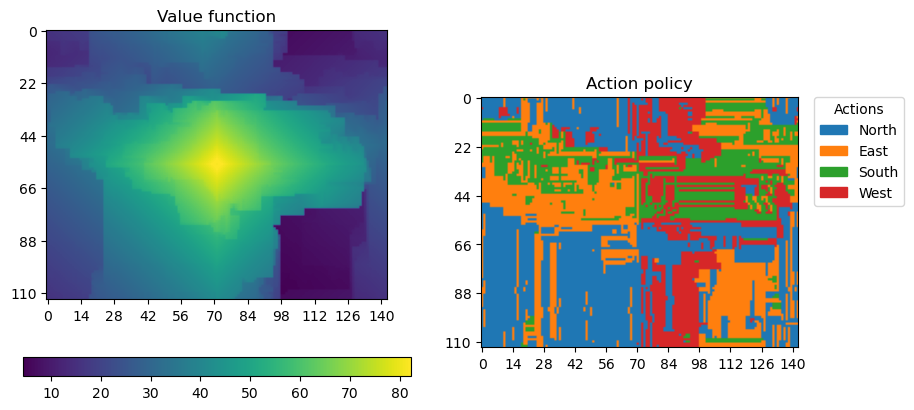

In [11]:
ag.value_function.plot()

## Run test

### Single point

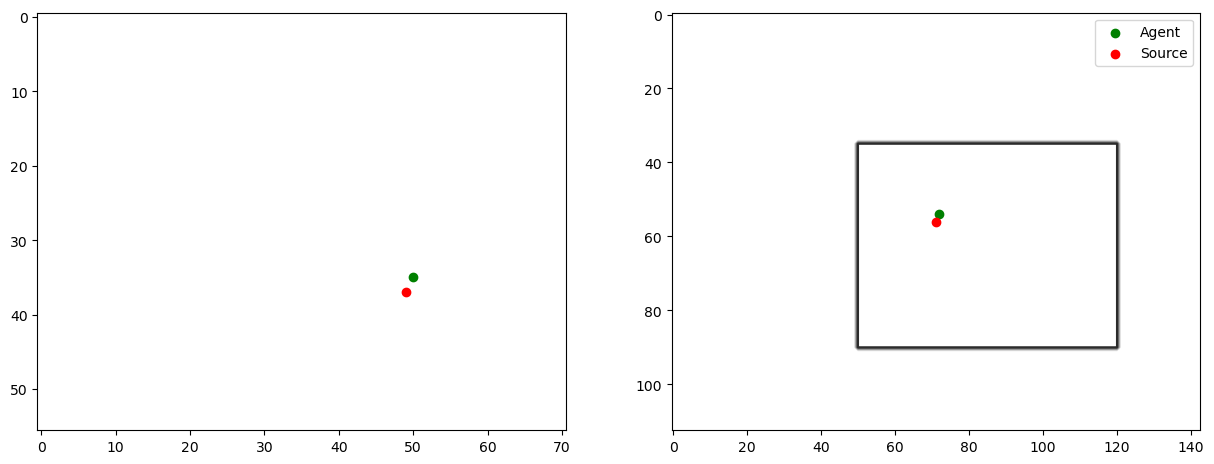

In [12]:
# PHYSICAL SPACE
source_point = (np.random.random(2) * tank_size).astype(int)
agent_start = (np.random.random(2) * tank_size).astype(int)

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,10))

ax0.imshow(np.zeros(tank_size), cmap='Greys')
ax0.scatter(source_point[1], source_point[0], c='red', label='Source')
ax0.scatter(agent_start[1], agent_start[0], c='green', label='Agent')

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size - source_point)

belief = np.zeros(space_shape)
belief[center_state[0]:center_state[0]+tank_size[0], center_state[1]:center_state[1]+tank_size[1]] = 1
belief /= np.sum(belief)

ax1.imshow(np.zeros(space_shape), cmap='Greys')
ax1.contour(belief, cmap='Greys')
# ax1.invert_yaxis()
ax1.scatter(agent_start_state[1], agent_start_state[0], c='green', label='Agent')
ax1.scatter(tank_size[1], tank_size[0], c='red', label='Source')
ax1.legend()

In [13]:
belief = BeliefSet(model=ag.model, beliefs=[Belief(model=ag.model, values=belief.ravel())])
hist = run_test(agent=ag,
                start_points=agent_start_state[None,:],
                horizon=max_steps,
                initialization_values={'belief': belief},
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

Simulations done in 0.297s:
Simulations reached goal: 1/1 (0 failures (reached horizon: 0)) (100.00% success)
 - Average step count:                 60.000 +- 0.00 (Successful only: 60.000 +- nan)
 - Extra steps:                        58.000 +- 0.00 (Successful only: 58.000 +- nan)
 - Average discounted rewards (ADR):   0.547 +- 0.00 (Successful only: 0.547 +- nan)
 - Tmin/T:                             0.033 +- 0.00 (Successful only: 0.033 +- nan)


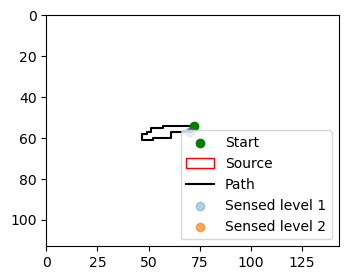

In [14]:
hist.plot()

### Experimental data

In [17]:
df = pd.read_csv(experiment_data_file)

In [18]:
exp_source_indices = df[['y_food_cm','x_food_cm']].to_numpy().astype(float)
exp_agent_indices = df[['y0_cm', 'x0_cm']].to_numpy().astype(float)

exp_source_indices /= multiplier
exp_agent_indices /= multiplier

exp_source_indices = exp_source_indices.astype(int)
exp_agent_indices = exp_agent_indices.astype(int)

In [19]:
# Generation of points
n = len(exp_source_indices)

# STATE SPACE
center_state = exp_agent_indices
agent_start_state = center_state + (tank_size[None,:] - exp_source_indices)

beliefs = []

for center, start in zip(center_state, agent_start_state):
    belief = np.zeros(space_shape)
    belief[center[0]:center[0]+tank_size[0], center[1]:center[1]+tank_size[1]] = 1
    belief /= np.sum(belief)

    beliefs.append(belief.flatten())

beliefs = np.array(beliefs)

In [20]:
all_hist = run_test(agent=ag,
                    start_points=agent_start_state,
                    environment=env,
                    horizon=max_steps,
                    initialization_values={'belief': BeliefSet(ag.model, beliefs)},
                    use_gpu=True,
                    print_stats=True)

Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

Simulations done in 2.758s:
Simulations reached goal: 43/116 (73 failures (reached horizon: 73)) (37.07% success)
 - Average step count:                 436.819 +- 160.02 (Successful only: 280.326 +- 175.72)
 - Extra steps:                        398.922 +- 154.28 (Successful only: 247.907 +- 168.41)
 - Average discounted rewards (ADR):   0.081 +- 0.20 (Successful only: 0.209 +- 0.29)
 - Tmin/T:                             0.147 +- 0.22 (Successful only: 0.265 +- 0.32)


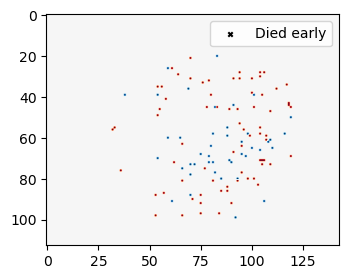

In [21]:
all_hist.plot_successes()

In [22]:
if not os.path.isdir(test_result_folder):
    os.mkdir(test_result_folder)

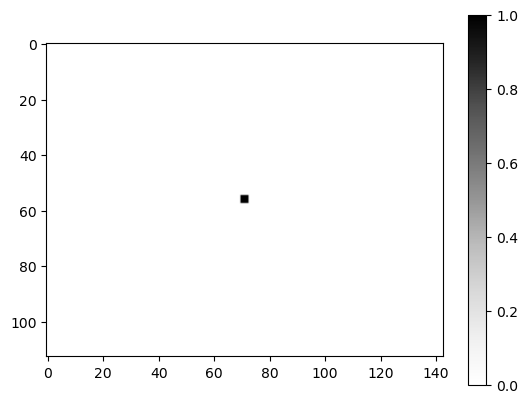

In [23]:
plt.imshow(odor_field, cmap='Greys')
plt.colorbar()
plt.savefig(test_result_folder + 'plume.png')

In [24]:
all_hist.save(folder=test_result_folder)

Simulations saved to: ./results-only_legs-20250110_152901/Simulations-s_113_143-n_116-20250110_152917-horizon_529.csv
Simulation's analysis saved to: ./results-only_legs-20250110_152901/Simulations-s_113_143-n_116-20250110_152917-horizon_529-analysis.csv


### Results

In [25]:
# Computing the amount of steps out of bounds
list_steps_out_of_bounds = []

for traj in range(len(exp_agent_indices)):
    # Retrieving sim
    sim = all_hist.simulation_dfs[traj]

    # Compute shift
    start_coord = sim[['y', 'x']].to_numpy()[0]
    shift = start_coord - exp_agent_indices[traj]

    # Retrieving sequence
    seq = sim[['y','x']].to_numpy() - shift[None,:]

    # Computing steps out of bounds
    steps_out_of_bounds = np.sum(np.any((seq < 0) | (seq >= tank_size), axis=1))

    # Compute the bounds for 5% and 10% of tank_size
    bounds_5_percent = tank_size * 0.05
    bounds_10_percent = tank_size * 0.10
    bounds_25_percent = tank_size * 0.25

    # Compute steps out of bounds by 5% and 10% using Manhattan distance
    steps_out_of_bounds_5_percent = np.sum(np.any((seq < -bounds_5_percent) | (seq >= tank_size + bounds_5_percent), axis=1))
    steps_out_of_bounds_10_percent = np.sum(np.any((seq < -bounds_10_percent) | (seq >= tank_size + bounds_10_percent), axis=1))
    steps_out_of_bounds_25_percent = np.sum(np.any((seq < -bounds_25_percent) | (seq >= tank_size + bounds_25_percent), axis=1))

    # Append the results to the list
    list_steps_out_of_bounds.append([steps_out_of_bounds, steps_out_of_bounds_5_percent, steps_out_of_bounds_10_percent, steps_out_of_bounds_25_percent])

array_steps_out_of_bounds = np.array(list_steps_out_of_bounds)
out_of_bounds_amount = np.sum(array_steps_out_of_bounds > 0, axis=1)

count_out_of_bounds = len(np.argwhere(array_steps_out_of_bounds[:,0]))

print(f'Simulations with steps out of bounds: {count_out_of_bounds} / {len(array_steps_out_of_bounds[:,0])}' + ('' if count_out_of_bounds == 0 else f' (avg length {np.mean(array_steps_out_of_bounds[array_steps_out_of_bounds[:,0] > 0, 0]):.2f})'))
tot = 0
for i, bound in enumerate([0, 5, 10, 25]):
    count = np.sum(out_of_bounds_amount == i)
    tot += count
    print(f'   - Inside {bound}%: {tot}')

Simulations with steps out of bounds: 0 / 116
   - Inside 0%: 116
   - Inside 5%: 116
   - Inside 10%: 116
   - Inside 25%: 116


In [26]:
res_sim_df = all_hist.analysis_df

res_sim_df['steps_in_05perc_marg'] = [None]*4 + array_steps_out_of_bounds[:,0].tolist()
res_sim_df['steps_in_10perc_marg'] = [None]*4 + array_steps_out_of_bounds[:,1].tolist()
res_sim_df['steps_in_25perc_marg'] = [None]*4 + array_steps_out_of_bounds[:,2].tolist()
res_sim_df['steps_out_25perc_marg'] = [None]*4 + array_steps_out_of_bounds[:,3].tolist()

# 0: no out of bounds, 1: < 5% out of bounds, 2: < 10% out of bounds, 3: < 25% out of bounds, 4: > 25% out of bounds
res_sim_df['tank_leaving_amount'] = [None]*4 + out_of_bounds_amount.tolist()

# Adding agent and source position info to result dataframe
res_sim_df['y_source_cm'] = [None]*4 + (exp_source_indices[:,0] * multiplier).tolist()
res_sim_df['x_source_cm'] = [None]*4 + (exp_source_indices[:,1] * multiplier).tolist()
res_sim_df['y_agent_cm'] = [None]*4 + (exp_agent_indices[:,0] * multiplier).tolist()
res_sim_df['x_agent_cm'] = [None]*4 + (exp_agent_indices[:,1] * multiplier).tolist()

res_sim_df = res_sim_df.drop(columns=['discounted_rewards'])

res_sim_df

,y,x,optimal_steps_count,converged,reached_horizon,steps_taken,extra_steps,t_min_over_t,steps_in_05perc_marg,steps_in_10perc_marg,steps_in_25perc_marg,steps_out_25perc_marg,tank_leaving_amount,y_source_cm,x_source_cm,y_agent_cm,x_agent_cm
mean,NaN,NaN,NaN,0.37069,0.62931,436.818966,398.922414,0.147193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
standard_deviation,NaN,NaN,NaN,0.482989,0.482989,160.017003,154.275512,0.215637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
success_mean,NaN,NaN,NaN,1.0,0.0,280.325581,247.906977,0.265106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
success_standard_deviation,NaN,NaN,NaN,0.0,0.0,175.719436,168.407077,0.323779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
run_0,87.0,57.0,44.0,False,True,529.000000,485.000000,0.083176,0.0,0.0,0.0,0.0,0.0,32.0,24.0,81.6,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_111,67.0,91.0,30.0,False,True,529.000000,499.000000,0.056711,0.0,0.0,0.0,0.0,0.0,48.0,28.8,65.6,60.8
run_112,66.0,104.0,42.0,True,False,518.000000,476.000000,0.081081,0.0,0.0,0.0,0.0,0.0,48.0,20.8,64.0,73.6
run_113,91.0,61.0,44.0,True,False,504.000000,460.000000,0.087302,0.0,0.0,0.0,0.0,0.0,12.8,78.4,68.8,62.4
run_114,68.0,75.0,15.0,True,False,65.000000,50.000000,0.230769,0.0,0.0,0.0,0.0,0.0,60.8,68.8,80.0,75.2


In [27]:
res_sim_df.to_csv(test_result_folder + f'results_{all_hist.start_time.strftime("%Y%m%d_%H%M%S")}.csv')

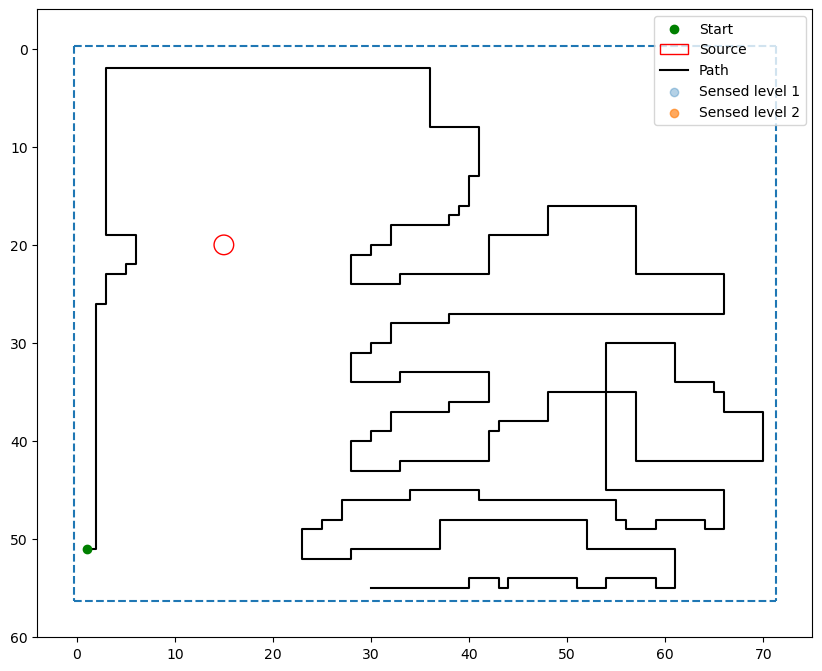

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = exp_agent_indices,
                        exp_source = exp_source_indices,
                        t_size = tank_size,
                        traj = 0,
                        ax = ax)

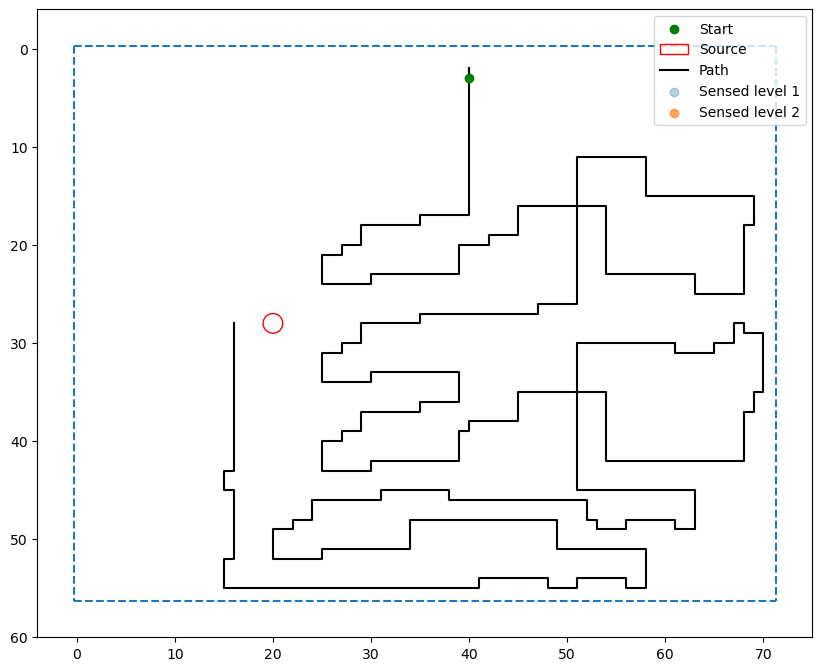

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = exp_agent_indices,
                        exp_source = exp_source_indices,
                        t_size = tank_size,
                        traj = 10,
                        ax = ax)

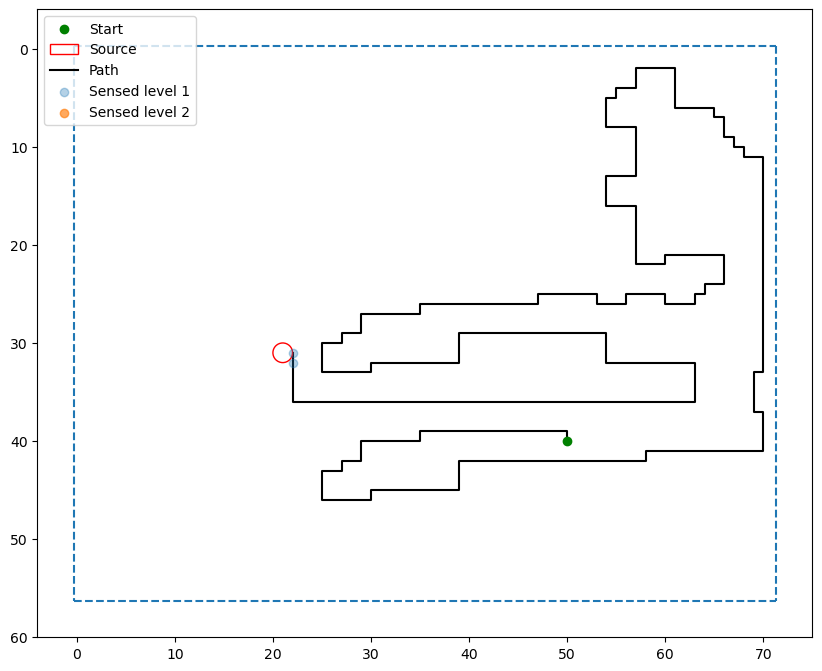

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = exp_agent_indices,
                        exp_source = exp_source_indices,
                        t_size = tank_size,
                        traj = 20,
                        ax = ax)

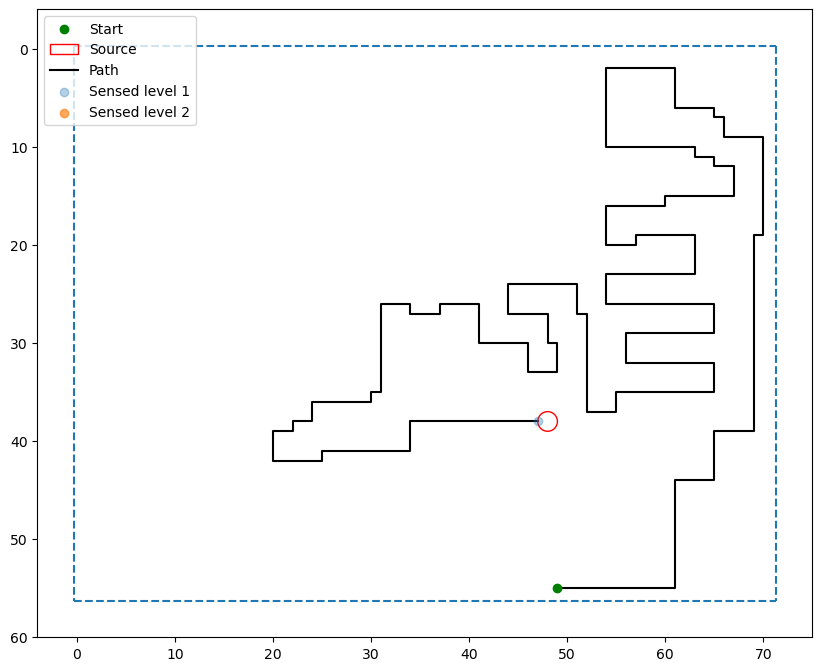

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = exp_agent_indices,
                        exp_source = exp_source_indices,
                        t_size = tank_size,
                        traj = 30,
                        ax = ax)

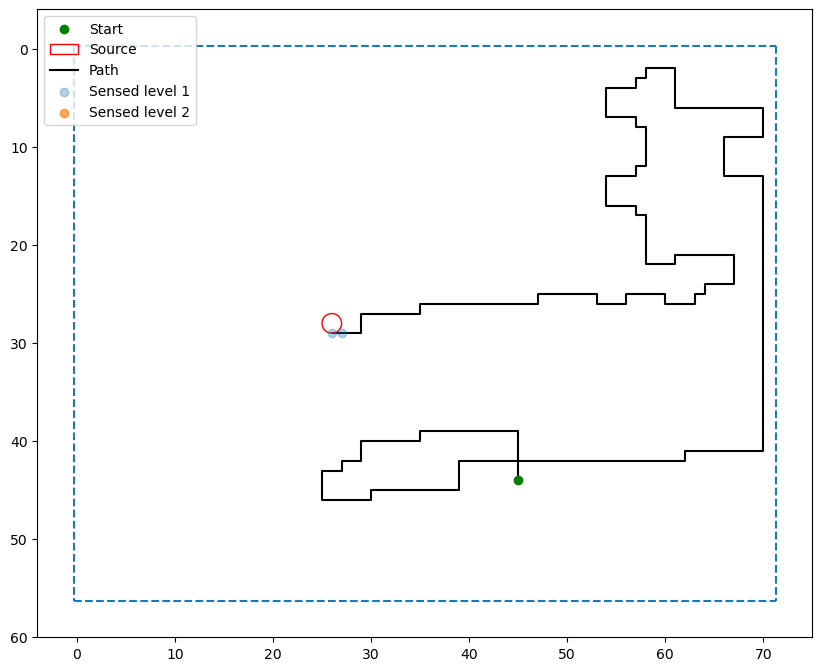

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = exp_agent_indices,
                        exp_source = exp_source_indices,
                        t_size = tank_size,
                        traj = 40,
                        ax = ax)

In [33]:
# Save all trajectories to folder
if not os.path.isdir(test_result_folder + 'trajectories/'):
    os.mkdir(test_result_folder + 'trajectories/')

out_of_traj_append = ['', '-in_05perc_marg', '-in_10perc_marg', '-in_25perc_marg', '-out_25perc_marg']

for i in range(len(exp_agent_indices)):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_trajectory_in_tank(h = all_hist,
                            exp_agent = exp_agent_indices,
                            exp_source = exp_source_indices,
                            t_size = tank_size,
                            traj = i,
                            ax = ax)

    plt.savefig(test_result_folder + 'trajectories/' + f'run-{i}{out_of_traj_append[out_of_bounds_amount[i]]}.png')
    plt.close(fig)

## Plots

In [34]:
a_df = all_hist.analysis_df
runs_df = a_df[[str(i).startswith('run_') for i in a_df.index]]
run_is_success = ~runs_df['reached_horizon'].astype(bool)
success_runs_df = runs_df.loc[run_is_success]

In [35]:
plot_folders = ['plots_in_0perc_marg/', 'plots_in_5perc_marg/', 'plots_in_10perc_marg/', 'plots_in_25perc_marg/', 'plots_all/']

# Create folders for plots
for folder in plot_folders:
    if not os.path.isdir(test_result_folder + folder):
        os.mkdir(test_result_folder + folder)

### Time taken plots

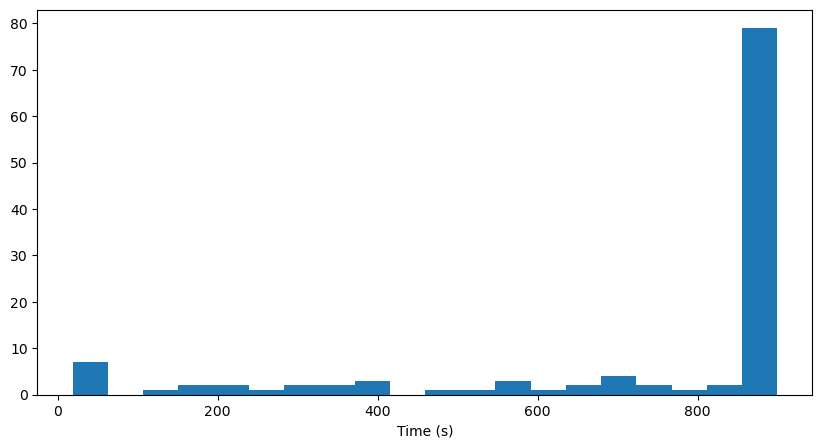

In [36]:
ax = (runs_df['steps_taken'] * step_dt).hist(grid=False, bins=20, figsize=(10,5))
ax.set_xlabel('Time (s)')
plt.show()

In [37]:
# Saving the plots
for i, folder in enumerate(plot_folders):
    filtered_runs_df = runs_df[out_of_bounds_amount <= i]
    ax = (filtered_runs_df['steps_taken'] * step_dt).hist(grid=False, bins=20, figsize=(10,5))
    ax.set_xlabel('Time (s)')
    plt.savefig(test_result_folder + folder + 'time_taken.png')
    plt.close()

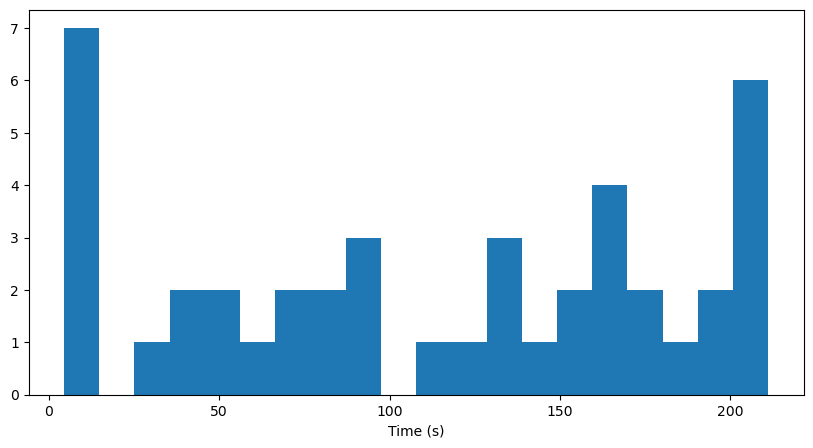

In [38]:
# Success only!
ax = (success_runs_df['steps_taken'] * dt).hist(grid=False, bins=20, figsize=(10,5))
ax.set_xlabel('Time (s)')
plt.show()

In [39]:
# Saving the plots
for i, folder in enumerate(plot_folders):
    filtered_success_runs_df = success_runs_df[(out_of_bounds_amount <= i)[run_is_success]]
    ax = (filtered_success_runs_df['steps_taken'] * step_dt).hist(grid=False, bins=20, figsize=(10,5))
    ax.set_xlabel('Time (s)')
    plt.savefig(test_result_folder + folder + 'time_taken_success_only.png')
    plt.close()

### Distance plots

In [40]:
# Saving the plots
# Division by 100 to convert to meters
for i, folder in enumerate(plot_folders):
    filtered_runs_df = runs_df[out_of_bounds_amount <= i]
    ax = ((filtered_runs_df['steps_taken'] * step_dist) / 100).hist(grid=False, bins=20, figsize=(10,5))
    ax.set_xlabel('Distance (m)')
    plt.savefig(test_result_folder + folder + 'distance.png')
    plt.close()

In [41]:
# Saving the plots
# Division by 100 to convert to meters
for i, folder in enumerate(plot_folders):
    filtered_success_runs_df = success_runs_df[(out_of_bounds_amount <= i)[run_is_success]]
    ax = ((filtered_success_runs_df['steps_taken'] * step_dist) / 100).hist(grid=False, bins=20, figsize=(10,5))
    ax.set_xlabel('Distance (m)')
    plt.savefig(test_result_folder + folder + 'distance_success_only.png')
    plt.close()

## Grid plots

In [42]:
all_success_array = []
all_speed_array = []
all_speed_success_array = []
all_count_array = []
all_count_success_array = []

for i, folder in enumerate(plot_folders):
    filtered_runs_df = runs_df[out_of_bounds_amount <= i]
    filtered_success_runs_df = success_runs_df[(out_of_bounds_amount <= i)[run_is_success]]

    # Retrieving successes and speed from dataframe
    successes = np.array(filtered_runs_df['converged'])
    speed = np.array(filtered_runs_df['steps_taken'])
    speed_success = np.array(filtered_success_runs_df['steps_taken'])

    # Compute the grid to use
    point_array = exp_source_indices[out_of_bounds_amount <= i] # exp_agent_indices or exp_source_indices

    grid = np.array([5,8])
    cell_indices = np.array(list(np.ndindex(tuple(grid))))
    cell_sizes = tank_size / grid

    point_cell = (point_array / cell_sizes).astype(int)

    # Compute successes and speeds in the grid
    success_array = np.zeros(grid, dtype=float)
    speed_array = np.zeros(grid, dtype=float)
    speed_success_array = np.zeros(grid, dtype=float)
    count_array = np.zeros(grid, dtype=int)
    count_success_array = np.zeros(grid, dtype=int)

    for cell in cell_indices:
        point_in_cell = np.all(point_cell == cell, axis=1)
        count_in_cell = np.sum(point_in_cell)
        count_array[*cell] = count_in_cell
        if count_in_cell == 0:
            continue

        success_perc = np.mean(successes[point_in_cell])
        average_speed = np.mean(speed[point_in_cell])

        success_array[*cell] = success_perc
        speed_array[*cell] = average_speed

        count_in_cell_success = np.sum(point_in_cell[run_is_success[out_of_bounds_amount <= i]])
        count_success_array[*cell] = count_in_cell_success
        if count_in_cell_success == 0:
            continue

        average_speed_success = np.mean(speed_success[point_in_cell[run_is_success[out_of_bounds_amount <= i]]])
        speed_success_array[*cell] = average_speed_success

    all_success_array.append(success_array)
    all_speed_array.append(speed_array)
    all_speed_success_array.append(speed_success_array)
    all_count_array.append(count_array)
    all_count_success_array.append(count_success_array)

### Convergence plot

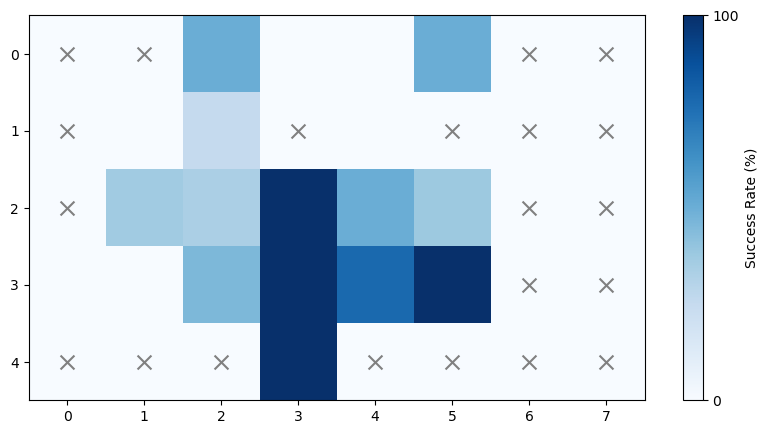

In [43]:
plt.figure(figsize=(10,5))

plt.imshow(all_success_array[-1] * 100, cmap='Blues', vmin=0, vmax=100)
cbar = plt.colorbar(ticks=[0,100])
cbar.set_label('Success Rate (%)')

no_sim = np.argwhere(all_count_array[-1] == 0)
plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

plt.show()

In [44]:
for i, folder in enumerate(plot_folders):
    plt.figure(figsize=(10,5))

    plt.imshow(all_success_array[i] * 100, cmap='Blues', vmin=0, vmax=100)
    cbar = plt.colorbar(ticks=[0,100])
    cbar.set_label('Success Rate (%)')

    no_sim = np.argwhere(all_count_array[i] == 0)
    plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

    plt.savefig(test_result_folder + folder + 'grid_success_rate.png')
    plt.close()

### Time Taken plots

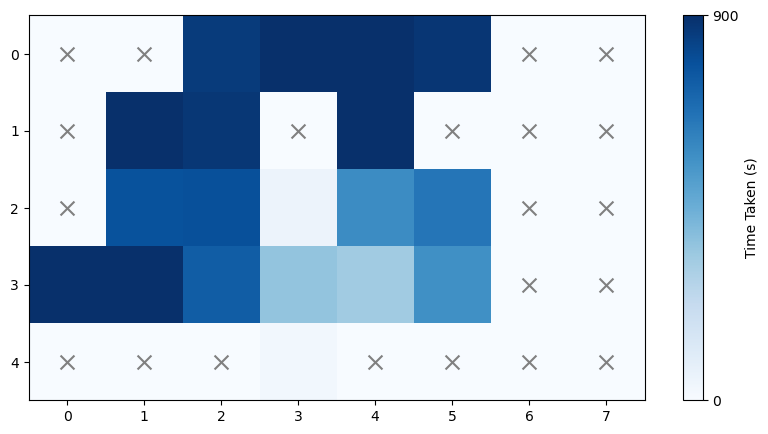

In [45]:
plt.figure(figsize=(10,5))

upper_bound = (np.ceil(np.max(all_speed_array[-1] * step_dt) / 100) * 100).astype(int)
plt.imshow(all_speed_array[-1] * step_dt, cmap='Blues', vmin=0, vmax=upper_bound)
cbar = plt.colorbar(ticks=[0,upper_bound])
cbar.set_label('Time Taken (s)')

no_sim = np.argwhere(all_count_array[-1] == 0)
plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

plt.show()

In [46]:
for i, folder in enumerate(plot_folders):
    plt.figure(figsize=(10,5))

    upper_bound = (np.ceil(np.max(all_speed_array[i] * step_dt) / 100) * 100).astype(int)
    plt.imshow(all_speed_array[i] * step_dt, cmap='Blues', vmin=0, vmax=upper_bound)
    cbar = plt.colorbar(ticks=[0,upper_bound])
    cbar.set_label('Time Taken (s)')

    no_sim = np.argwhere(all_count_array[i] == 0)
    plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

    plt.savefig(test_result_folder + folder + 'grid_time_taken.png')
    plt.close()

In [47]:
for i, folder in enumerate(plot_folders):
    plt.figure(figsize=(10,5))

    upper_bound = (np.ceil(np.max(all_speed_success_array[i] * step_dt) / 100) * 100).astype(int)
    plt.imshow(all_speed_success_array[i] * step_dt, cmap='Blues', vmin=0, vmax=upper_bound)
    cbar = plt.colorbar(ticks=[0,upper_bound])
    cbar.set_label('Time Taken (s)')

    no_sim = np.argwhere(all_count_success_array[i] == 0)
    plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

    plt.savefig(test_result_folder + folder + 'grid_time_taken_success_only.png')
    plt.close()

### Distance plots

In [48]:
for i, folder in enumerate(plot_folders):
    plt.figure(figsize=(10,5))

    upper_bound = (np.ceil(np.max(all_speed_array[i] * step_dist) / 100)).astype(int)
    plt.imshow((all_speed_array[i] * step_dist) / 100, cmap='Blues', vmin=0, vmax=upper_bound)
    cbar = plt.colorbar(ticks=[0,upper_bound])
    cbar.set_label('Distance (m)')

    no_sim = np.argwhere(all_count_array[i] == 0)
    plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

    plt.savefig(test_result_folder + folder + 'grid_distance.png')
    plt.close()

In [49]:
for i, folder in enumerate(plot_folders):
    plt.figure(figsize=(10,5))

    upper_bound = (np.ceil(np.max(all_speed_success_array[i] * step_dist) / 100)).astype(int)
    plt.imshow((all_speed_success_array[i] * step_dist) / 100, cmap='Blues', vmin=0, vmax=upper_bound)
    cbar = plt.colorbar(ticks=[0,upper_bound])
    cbar.set_label('Distance (m)')

    no_sim = np.argwhere(all_count_success_array[i] == 0)
    plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

    plt.savefig(test_result_folder + folder + 'grid_distance_success_only.png')
    plt.close()

## Results

In [50]:
import os
import re

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from PIL import Image

### Plots Results

In [51]:
folder = test_result_folder

plot_sets = [
    'No filter',
    'Filtered all exitting',
    'Filtered all out of 5% margin',
    'Filtered all out of 10% margin',
    'Filtered all out of 25% margin'
]

# Create pdf folder
if not os.path.isdir(folder + 'results_pdfs/'):
    os.mkdir(folder + 'results_pdfs/')

for i, plot_folder_name in enumerate(['plots_all', 'plots_in_0perc_marg', 'plots_in_5perc_marg', 'plots_in_10perc_marg', 'plots_in_25perc_marg']):
    plot_folder = folder + plot_folder_name + '/'

    # Basic setup
    pdf_file_name = folder + 'results_pdfs/' + 'results_' + plot_folder_name + '.pdf'
    c = canvas.Canvas(pdf_file_name, pagesize=A4)
    width, height = A4
    margin = 10

    # List of png files in the specified order
    png_files = ['grid_success_rate', 'time_taken', 'grid_time_taken', 'distance', 'grid_distance']
    png_files = [os.path.join(plot_folder, f'{name}.png') for name in png_files]

    x_left = margin
    x_right = width / 2 + margin
    y = height - margin

    # Set title
    c.setFont("Helvetica-Bold", 18)
    c.drawString(x_left, y - 15, f"Results - Only legs - {plot_sets[i]}")
    y -= 20

    for png_file in png_files:
        if '/time_taken.png' in png_file:
            c.setFont("Helvetica-Bold", 12)
            c.drawString(x_left + margin, y - 15, "Speed of the agent (seconds)")
            y -= 20

        if '/distance.png' in png_file:
            c.setFont("Helvetica-Bold", 12)
            c.drawString(x_left + margin, y - 15, "Distance travelled by the agent (meters)")
            y -= 20

        img = Image.open(png_file)
        img_width, img_height = img.size

        # Resize the image to fit the PDF page
        aspect = img_width / img_height
        if aspect > 1:
            img_width = (width / 2) - (2 * margin)
            img_height = img_width / aspect
        else:
            img_height = (height / 2) - (2 * margin)
            img_width = img_height * aspect

        if y - img_height < margin:
            c.showPage()
            y = height - margin

        c.drawImage(png_file, x_left, y - img_height, img_width, img_height)
        if 'grid_success_rate' in png_file: # Add the plume image
            img = Image.open(folder + 'plume.png')
            plume_img_width, plume_img_height = img.size
            plume_img_width = min(plume_img_width, img_width)
            plume_img_height = min(plume_img_height, img_height)

            # Resize the image to fit the PDF page
            aspect = plume_img_width / plume_img_height
            if aspect > 1:
                plume_img_width = (width / 2) - (2 * margin)
                plume_img_height = plume_img_width / aspect
            else:
                plume_img_height = (height / 2) - (2 * margin)
                plume_img_width = plume_img_height * aspect

            c.drawImage(folder + 'plume.png', x_right, y - img_height, plume_img_width, plume_img_height)
        else: # Plotting _success_only versions of the plots except for the success_rate
            c.drawImage(png_file.replace('.png', '_success_only.png'), x_right, y - img_height, img_width, img_height)
        y -= img_height + margin

    c.save()
    print(f"PDF saved as {pdf_file_name}")

PDF saved as ./results-only_legs-20250110_152901/results_pdfs/results_plots_all.pdf
PDF saved as ./results-only_legs-20250110_152901/results_pdfs/results_plots_in_0perc_marg.pdf
PDF saved as ./results-only_legs-20250110_152901/results_pdfs/results_plots_in_5perc_marg.pdf
PDF saved as ./results-only_legs-20250110_152901/results_pdfs/results_plots_in_10perc_marg.pdf
PDF saved as ./results-only_legs-20250110_152901/results_pdfs/results_plots_in_25perc_marg.pdf


### Trajectories

In [52]:
folder = test_result_folder

# Define the folder containing the trajectory images
trajectory_folder = os.path.join(folder, 'trajectories')

# Get the list of trajectory PNG files
trajectory_files = [f for f in os.listdir(trajectory_folder) if f.endswith('.png')]

# Sort the files by the number in the filename
trajectory_files.sort(key=lambda x: int(re.search(r'run-(\d+)', x).group(1)))

# Create a new PDF file for the trajectories
trajectory_pdf_file_name = os.path.join(folder + 'results_pdfs/', 'trajectories.pdf')
c = canvas.Canvas(trajectory_pdf_file_name, pagesize=A4)
width, height = A4
margin = 5

# Set the number of columns
num_columns = 4
column_width = (width - (num_columns + 1) * margin) / num_columns

# Initialize the position
x = margin
y = height - margin

for i, trajectory_file in enumerate(trajectory_files):
    # Open the image
    img = Image.open(os.path.join(trajectory_folder, trajectory_file))
    img_width, img_height = img.size

    # Resize the image to fit the column width
    aspect = img_width / img_height
    img_width = column_width
    img_height = img_width / aspect

    # Check if we need to move to the next row
    if x + img_width + margin > width:
        x = margin
        y -= img_height + 2 * margin + 15  # 15 for the text height

    # Check if we need to add a new page
    if y - img_height < margin:
        c.showPage()
        x = margin
        y = height - margin

    # Draw the file name above the image
    c.setFont("Helvetica", 8)
    c.drawString(x, y - 13, trajectory_file.removesuffix('.png'))

    # Draw the image
    c.drawImage(os.path.join(trajectory_folder, trajectory_file), x, y - img_height - 15, img_width, img_height)

    # Move to the next column
    x += img_width + margin

# Save the PDF
c.save()
print(f"Trajectory PDF saved as {trajectory_pdf_file_name}")

Trajectory PDF saved as ./results-only_legs-20250110_152901/results_pdfs/trajectories.pdf
